In [2]:
from networks.mpnet import MPNet
from networks.costnet import CostNet
from dataset.dataset import get_loader_cost

import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data, visualize_point

In [5]:
# setup = "subset"
setup = "default_norm"
# setup = "default_norm_aug"
# setup = "norm_nodiff_noaug_20step2e-2"
# setup = "norm_nodiff_noaug_5step2e-2"
# setup = "norm_nodiff_noaug_20step2e-3"
mpnet = MPNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4)


# setup = "default_norm_noaug_control"
# setup = "norm_nodiff_noaug_20step2e-2_control"

# mpnet = MPNet(ae_input_size=32, ae_output_size=128, in_channels=1, state_size=4, control_size=2)


model = "acrobot_obs"
env = 1
traj_id = 233
goal_radius = 2


mpnet.load_state_dict(torch.load('output/acrobot_obs/{}/mpnet/ep5000.pth'.format(setup)))
setup = "default_norm"

costnet = CostNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4, encoder=mpnet.encoder)
costnet.load_state_dict(torch.load('output/acrobot_obs/{}/cost_to_go/ep5000.pth'.format(setup)))
costnet.eval()

# mpnet.eval()
mpnet.train()

def evaluate(start_th, goal_th, env_vox, net):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    with torch.no_grad():
        sample = net(start_goal, env_vox)         
    return sample.clone()
def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    ax.scatter(start[0], start[1], color='orange')
    ax.scatter(goal[0], goal[1], color='red')
    ax.plot(path[:, 0], path[:, 1], color=color)
    ax.scatter(path[:, 0], path[:, 1], color='blue', s=3)
    ax.scatter(path[-1, 0], path[-1, 1], color='orange')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def distance(point1, point2):
    LENGTH = 20.
    x = np.cos(point1[0] - np.pi / 2)+np.cos(point1[0] + point1[1] - np.pi / 2)
    y = np.sin(point1[0] - np.pi / 2)+np.sin(point1[0] + point1[1] - np.pi / 2)
    x2 = np.cos(point2[0] - np.pi / 2)+np.cos(point2[0] + point2[1] - np.pi / 2)
    y2 = np.sin(point2[0] - np.pi / 2)+np.sin(point2[0] + point2[1] - np.pi / 2)
    return LENGTH*np.sqrt((x-x2)**2+(y-y2)**2)
env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()


In [6]:
import torch.nn.functional as F

system = "sst_envs"
batch = 128
train_loader, test_loader = get_loader_cost(system, model, batch_size=batch, setup=setup)
for data, label in test_loader:
    costnet.eval()
    eval_loss = []
    with torch.no_grad():
        if torch.cuda.is_available():
            data = data.cuda()
            label = label.cuda()   
            costnet.cuda()
        inputs = data[:,1:]
        envs = env_vox_all[(data[:,0]).long()].cuda()
        output = costnet(inputs, envs)
        loss = F.l1_loss(output, label)
        #loss = F.mse_loss(output, label)
        eval_loss.append(loss.item())
print("eval loss:{}".format(np.mean(eval_loss)))

eval loss:0.11244753003120422


In [7]:
env_vox = env_vox_all[env].float().unsqueeze(0).cpu()
costnet.cpu()
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']
print(ref_path_dict['cost'].sum())

7.119999999999999


In [8]:
# %matplotlib notebook
# endeff = np.array(endeff)
# node1 = np.array(node1)
# x1, y1, x2, y2 = visualize_point(ref_path[-1])
# plt.plot(endeff[:,0], endeff[:,1], color='skyblue')
# plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

# for i in range(endeff.shape[0]):
#     plt.plot([0, node1[i,0]], [0, node1[i,1]], color='black')
#     plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='black')

# plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
# plt.scatter(x2, y2, color='red')
# plt.xlim(-41, 40)
# plt.ylim(-41, 40)


In [10]:
node_id = 1
start = ref_path[node_id].copy()
gt = ref_path[node_id+1].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start[:2] /= np.pi
start[2:] /= 6
goal[:2] /= np.pi
goal[2:] /= 6

num_sample = 500

start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])

def plan_cost(state_th, goal_th, mpnet, costnet):
    sample = evaluate(state_th, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), mpnet)
#     print(sample)
    costs = evaluate(sample, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), costnet)
    return sample, costs

def select_sample(sample, cost):
    cost_sorted, indices = torch.sort(cost.reshape(-1))
    idx = indices[0]
    new_sample = sample[idx].repeat([num_sample, 1])
    return new_sample,cost[idx]

samples, cost = plan_cost(start_th, goal_th, mpnet, costnet)
new_sample, min_cost = select_sample(samples, cost)
new_sample[0], min_cost

tensor([[ 0.1243, -0.2878,  0.0841, -0.2757],
        [ 0.1290, -0.2813,  0.0894, -0.2713],
        [ 0.1259, -0.2845,  0.0985, -0.2866],
        ...,
        [ 0.1248, -0.2841,  0.1029, -0.2775],
        [ 0.1257, -0.2875,  0.0969, -0.2845],
        [ 0.1261, -0.2853,  0.0946, -0.2817]])


(tensor([ 0.1380, -0.2811,  0.0565, -0.1441]), tensor([ 6.4484]))

In [11]:
start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])


endeff = [[0, -40]]
node1 = [[0, -20]]
path = []
path.append(start_th[0].numpy())
min_cost = np.inf

for i in range(20):
    samples, cost = plan_cost(start_th, goal_th, mpnet, costnet)
    new_sample, new_cost = select_sample(samples, cost)
    
    print(new_sample[0], new_cost)
#     if new_cost < min_cost:
    if True:
        min_cost = new_cost
        start_th = new_sample
        if start_th[0, 0] > 1:
            start_th[:, 0] -= 2
        if start_th[0, 0] < -1:
            start_th[:, 0] += 2

        if start_th[0, 1] > 1:
            start_th[:, 1] -= 2
        if start_th[0, 1] < -1:
            start_th[:, 1] += 2

        if start_th[0, 2] > 1:
            start_th[:, 2] = 1
        if start_th[0, 2] < -1:
            start_th[:, 2] = -1

        if start_th[0, 3] > 1:
            start_th[:, 3] = 1
        if start_th[0, 3] < -1:
            start_th[:, 3] = -1

        ex1, ey1, ex2, ey2 = visualize_point(start_th.clone()[0] * torch.tensor([np.pi, np.pi, 6, 6]))
        endeff.append([ex2, ey2])
        node1.append([ex1, ey1])
        path.append(start_th[0].numpy().copy())
    
        dis = distance(start_th[0] * torch.tensor([np.pi, np.pi, 6, 6]), goal_th[0] * torch.tensor([np.pi, np.pi, 6, 6]))
        print(i,dis)
    if dis < goal_radius or min_cost < 0.2:
        break

tensor([[ 0.1258, -0.2898,  0.0915, -0.2836],
        [ 0.1283, -0.2903,  0.0936, -0.2855],
        [ 0.1266, -0.2868,  0.0891, -0.2813],
        ...,
        [ 0.1227, -0.3091,  0.0869, -0.2827],
        [ 0.1267, -0.3033,  0.0895, -0.2856],
        [ 0.1261, -0.2912,  0.0958, -0.2846]])
tensor([ 0.1131, -0.2980,  0.0763, -0.2447]) tensor([ 6.4884])
0 tensor(64.5401)
tensor([[ 0.1407, -0.3407,  0.0004, -0.1261],
        [ 0.1365, -0.3433,  0.0079, -0.1289],
        [ 0.1371, -0.3351,  0.0097, -0.1357],
        ...,
        [ 0.1351, -0.3423,  0.0019, -0.1251],
        [ 0.1393, -0.3382,  0.0101, -0.1325],
        [ 0.1319, -0.3361,  0.0051, -0.1164]])
tensor([-0.2447,  0.3682,  0.0477,  0.2973]) tensor([ 5.7784])
1 tensor(61.9555)
tensor([[-0.0287,  0.4345,  0.3930, -0.4524],
        [-0.1395,  0.5425,  0.4125, -0.3242],
        [-0.1071,  0.4509,  0.2079, -0.2264],
        ...,
        [-0.0676,  0.1993,  0.2063, -0.2538],
        [-0.0880,  0.4404,  0.3089, -0.2609],
        [-0.073

In [49]:
saved_path = np.array(path)[:, :4].copy()
saved_path[:, :2] *= np.pi
saved_path[:, 2:] *= 6
np.save('mpnet_path.npy', saved_path)

<IPython.core.display.Javascript object>


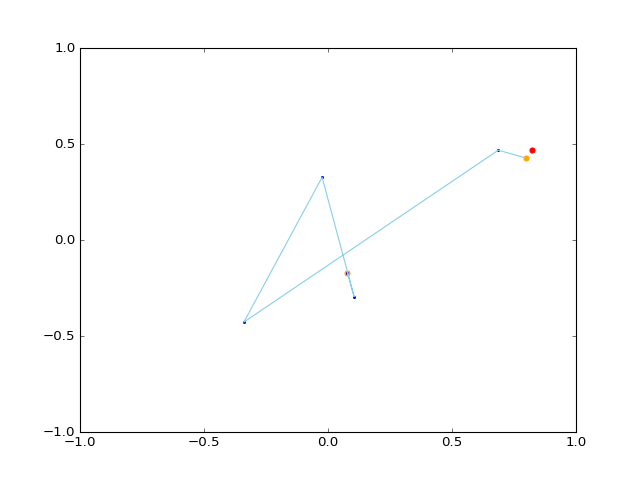

In [50]:
%matplotlib notebook
fig2, ax2 = plt.subplots()
visualize(path, start, goal, ax2)
# visualize(path_from_data, path_from_data[0], path_from_data[-1], ax2, color='green')

<IPython.core.display.Javascript object>


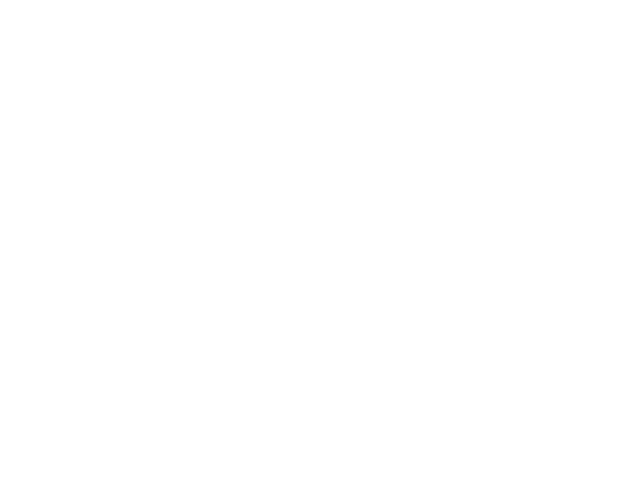

(-41, 40)

In [101]:
%matplotlib notebook

x1, y1, x2, y2 = visualize_point(start)
plt.plot([0, x1], [0, y1], color='blue')
plt.plot([x1, x2], [y1, y2], color='blue')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')


x1, y1, x2, y2 = visualize_point(gt)
plt.plot([0, x1], [0, y1], color='green')
plt.plot([x1, x2], [y1, y2], color='green')
plt.scatter(x1, y1, color='gray')
plt.scatter(x2, y2, color='red')

for i in range(samples.size(0)):
    x1, y1, x2, y2 = visualize_point(samples[i])
    plt.plot([0, x1], [0, y1], color='black')
    plt.plot([x1, x2], [y1, y2], color='black')
    plt.scatter(x1, y1, color='gray')
    plt.scatter(x2, y2, color='orange')
plt.xlim(-41, 40)
plt.ylim(-41, 40)